In [1]:
import os
import sys
parent = os.path.realpath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(parent)
import numpy as np
from databases.sql_connect import create_connection
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from databases.sql_connect import create_connection

_point = "\u00b7"

sns.set_theme()
sns.set(context="paper", style="darkgrid", font="Times New Roman")
cm = 1/2.54
DB_CORR = os.path.join(parent,"databases", "TEMPRO_DB230416_Corr.db")
assert(os.path.exists(DB_CORR))
FONTSIZE = 8

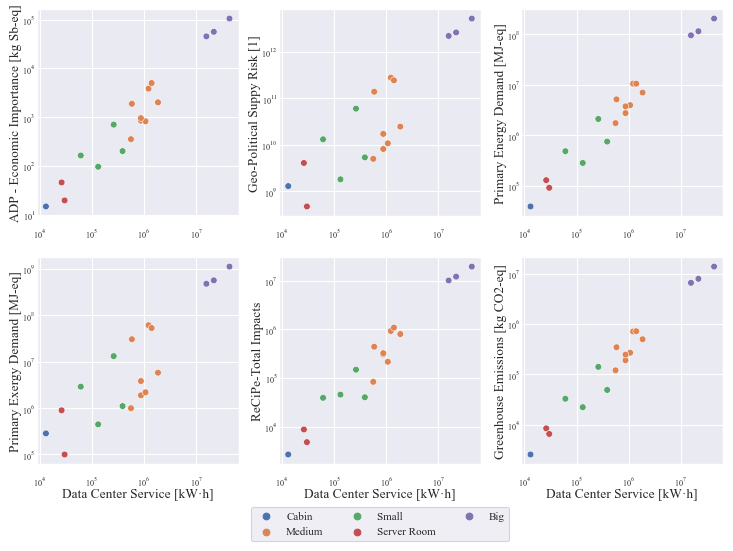

In [3]:
# get impacts of data centers

group = 6000

cats = {"EI-Minerals- Total": "ADP-EI",
        "GPR-Minerals- Total": "GPSR",
        "CED - total": "CED",
        "CExD - metals": "CExD",
        "ReCiPe Midpoint (E) - metal depletion (MDP)": "MDP",
        "ADP": "ADP",
        "ReCiPe Endpoint (E - A) - total (total)": "Total",
        "CML-climate change (GWP 100a)": "GWP"}

full_label= {'ADP-EI': 'ADP - Economic Importance [kg Sb-eq]',
 'GPSR': 'Geo-Political Suppy Risk [1]',
 'CED': 'Primary Energy Demand [MJ-eq]',
 'CExD': 'Primary Exergy Demand [MJ-eq]',
 'MDP': 'Metal Depletion Potential [kg Fe-eq]',
 'ADP': 'Abiotic Depletion Potential [kg Sb-eq]',
 'Total': 'ReCiPe-Total Impacts',
 'GWP': 'Greenhouse Emissions [kg CO2-eq]'}

conn = create_connection(DB_CORR)
query = f'SELECT * FROM [{group}LCAResults]'
df_lca = pd.read_sql_query(query, conn)
conn.close()
impacts = df_lca['Category'].unique()
#df_lca=df_lca[df_lca["ProductSystemID"]>4400]
df_ = []
for cat in cats.keys():
        df = df_lca[df_lca["Category"] == cat]
        df.set_index("ProductSystemID", inplace=True)
        df=df[["Result"]]
        df.columns=[cats[cat]]
        df_.append(df)


        #df_corr = df_heat_map.corr()
        #sns.heatmap(data=df_corr, cmap="viridis", annot=True, fmt=".2f", ax=ax)
        #fig.savefig(f"Correlations\heatmap_{group}.svg", bbox_inches='tight', dpi=600)

size_data = pd.read_excel("results_eval.xlsx", engine="openpyxl", sheet_name="Power")
size_data.set_index("ID", inplace=True)
size_data["kW-h"]=size_data["Power"]*(365*24-size_data["Downtime"])
size_data=size_data[["kW-h", "Category"]]
df_.append(size_data)
df_impacts = pd.concat(df_,axis=1)
df_impacts.rename(columns=cats)
df_impacts.head()
cm = 1/2.54 * 1.5
fig, axs = plt.subplots(2,3,figsize=(15*cm, 10*cm))
ax_l = list(axs[0]) + list(axs[1])
i=0
for _,col in cats.items():
    ax= ax_l[i]  
    i+=1
    sns.scatterplot(data=df_impacts, x= "kW-h",y=col, hue="Category", ax = ax)
    ax.set_ylabel(full_label[col], labelpad=0)
    if i>3:
        ax.set_xlabel(f"Data Center Service [kW{_point}h]",labelpad=0)
    else:
         ax.set_xlabel("")
    ax.set_yscale("log")
    ax.set_xscale("log")
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FONTSIZE*0.75)
        label.set_x(0.05)

    if i != 4:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1.7, -0.4),
                  
                  loc= 'lower center', fontsize=FONTSIZE, ncols=3)   
fig.savefig(f"DC-Size/size_correlations.png", bbox_inches='tight',dpi=600)
